<a href="https://colab.research.google.com/github/jon-shemmell-uow/MUAPmodels/blob/main/MUAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

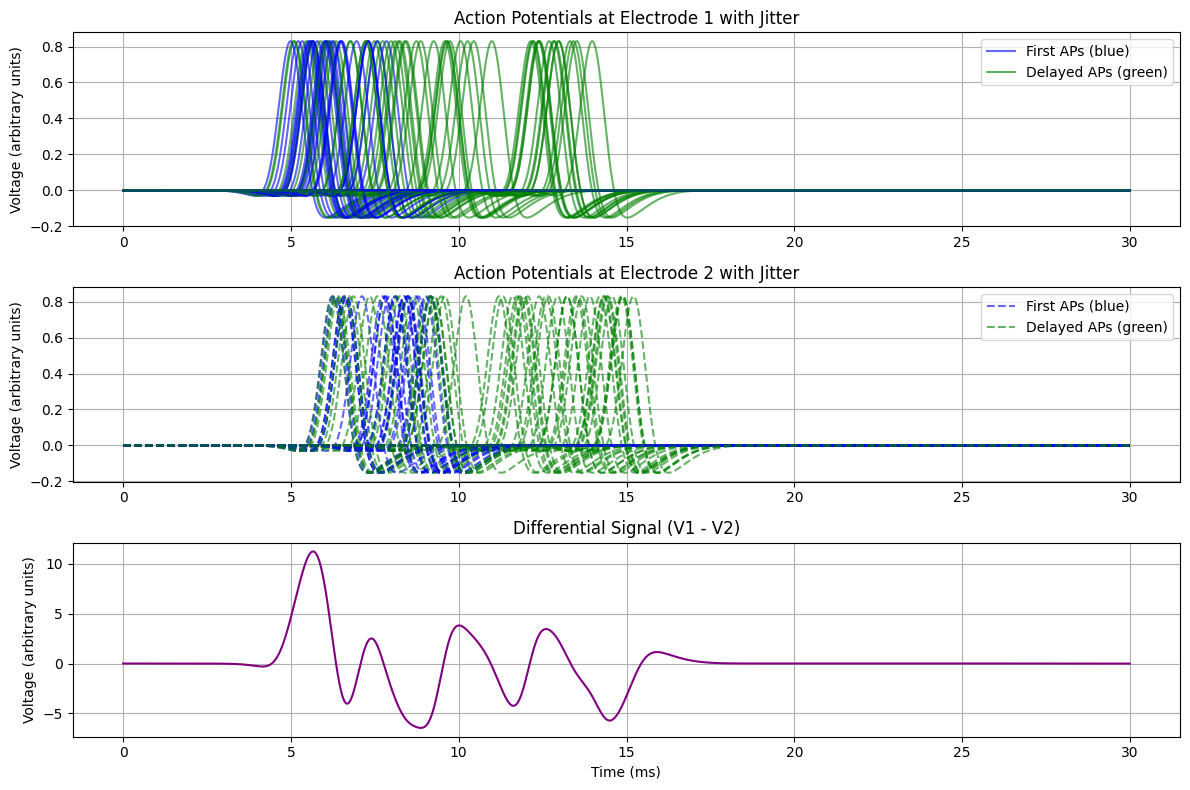

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# === Step 1: Simulation settings ===
x1 = 20  # Position of Electrode 1 (mm)
d = 5     # Distance between electrodes (mm)
v = 4     # Conduction velocity (mm/ms)
dt = 0.01  # Time step (ms)
jitter_range_first = 3  # Jitter range for the first series (ms)
jitter_range_second = 4.5  # Jitter range for the second series (ms)
num_ap = 50       # Number of action potentials in each series
second_ap_series = True  # Set to True to include second AP series, False to exclude
AP2delay = 4.5

x2 = x1 + d  # Electrode 2 position

# Fixed simulation window: 50 ms
T = 30
times = np.arange(0, T, dt)

# === Step 2: Realistic extracellular action potential shape ===
def realistic_ap(x, t, v=v):
    # Time-shifted based on location and conduction velocity
    tau = (x - v * t)

    # Custom action potential shape without initial negative deflection
    return (
        1.0 * np.exp(-((tau) / 2.0) ** 2)  # Main depolarization phase (positive)
        - 0.2 * np.exp(-((tau + 2) / 5.0) ** 2)  # After-hyperpolarization bump
    )

# === Step 3: Simulate the signals at each electrode ===
def generate_ap_series(x, num_ap, jitter_range, delay=0):
    """ Generate a series of action potentials with jitter and optional delay. """
    # Create a single action potential at time t=0
    ap_signal = np.array([realistic_ap(x, t) for t in times])

    # Apply jitter by shifting the start time of each AP signal
    jittered_signals = []
    for _ in range(num_ap):
        # Apply jittered start time
        jittered_start_time = np.random.uniform(-jitter_range, jitter_range) + delay

        # Shift the AP and clip it to fit within the simulation window
        shifted_signal = np.roll(ap_signal, int(jittered_start_time / dt))  # Shift by jittered time
        shifted_signal[:int(jittered_start_time / dt)] = 0  # Clip the start of the signal

        jittered_signals.append(shifted_signal)

    return np.array(jittered_signals)

# Generate action potentials for the first series at both electrodes (with jitter)
V1_first_series = generate_ap_series(x1, num_ap, jitter_range_first)
V2_first_series = generate_ap_series(x2, num_ap, jitter_range_first)

# If the second AP series is enabled, generate it with a delay
if second_ap_series:
    V1_second_series = generate_ap_series(x1, num_ap, jitter_range_second, delay=AP2delay)  # Second series with delay
    V2_second_series = generate_ap_series(x2, num_ap, jitter_range_second, delay=AP2delay)  # Second series with delay
else:
    V1_second_series = np.zeros_like(V1_first_series)
    V2_second_series = np.zeros_like(V2_first_series)

# === Step 4: Compute the differential signal ===
V1_combined = np.sum(V1_first_series, axis=0) + np.sum(V1_second_series, axis=0)
V2_combined = np.sum(V2_first_series, axis=0) + np.sum(V2_second_series, axis=0)
V_diff = V1_combined - V2_combined

# === Step 5: Plot the results ===
plt.figure(figsize=(12, 8))

# Plot: Action potentials at Electrode 1 (with jitter)
plt.subplot(3, 1, 1)
for i in range(num_ap):
    plt.plot(times, V1_first_series[i], color='blue', alpha=0.6)  # First series
    if second_ap_series:
        plt.plot(times, V1_second_series[i], color='green', alpha=0.6)  # Second series (delayed)

# Add legend for the first and second series at Electrode 1
plt.title('Action Potentials at Electrode 1 with Jitter')
plt.ylabel('Voltage (arbitrary units)')
plt.grid(True)
plt.legend(['First APs (blue)', 'Delayed APs (green)'] if second_ap_series else ['First series (blue)'])

# Plot: Action potentials at Electrode 2 (with jitter)
plt.subplot(3, 1, 2)
for i in range(num_ap):
    plt.plot(times, V2_first_series[i], color='blue', linestyle='--', alpha=0.6)  # First series
    if second_ap_series:
        plt.plot(times, V2_second_series[i], color='green', linestyle='--', alpha=0.6)  # Second series (delayed)

# Add legend for the first and second series at Electrode 2
plt.title('Action Potentials at Electrode 2 with Jitter')
plt.ylabel('Voltage (arbitrary units)')
plt.grid(True)
plt.legend(['First APs (blue)', 'Delayed APs (green)'] if second_ap_series else ['First series (blue)'])

# Plot: Differential signal
plt.subplot(3, 1, 3)
plt.plot(times, V_diff, color='purple')
plt.title('Differential Signal (V1 - V2)')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (arbitrary units)')
plt.grid(True)

plt.tight_layout()
plt.show()
